In [1]:
import os
import sys
import glob
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from PIL import Image
# from tqdm import tqdm
from scipy.stats import kendalltau

PROJECT_ROOT = os.path.abspath(os.path.join(sys.path[0], os.pardir))
sys.path.append(PROJECT_ROOT)


# Use the best checkpoint from a training run for inference
Given a folder of training outputs, open up the epoch-wise metrics file and identify the epoch with the lowest validation set loss.
Use the checkpoint from that epoch to run inference.

In [2]:
def get_best_checkpoint(train_output_folder):
    metrics_file = glob.glob(os.path.join(train_output_folder, "metrics*.json"))[0]
    with open(metrics_file, "r") as f:
        metrics = json.load(f)
    best_epoch = np.argmin(metrics["val_loss"])
    checkpoints_folder = os.path.join(train_output_folder, "checkpoints")
    best_checkpoint = glob.glob(os.path.join(checkpoints_folder, f"epoch{best_epoch}_*"))[0]
    return(best_checkpoint, best_epoch)


In [8]:
# get_best_checkpoint("../results/train_ranking_model/train_ranking_model_WESTB0_5")
# get_best_checkpoint("../results/train_ranking_model/annotator_labels/train_ranking_model_FOXRC_2")
get_best_checkpoint("../results/tmp_during_refactor/ranking_no_winter_no_nighttime/random_pair_sampling/oracle_annotator_margin_0.25/5000_pairs/train_ranking_model_AVERYBB_1/")


('../results/tmp_during_refactor/ranking_no_winter_no_nighttime/random_pair_sampling/oracle_annotator_margin_0.25/5000_pairs/train_ranking_model_AVERYBB_1/checkpoints/epoch28_ranking_margin_0.25_randompairs_5000_AVERYBB_augment_normalize_1691.ckpt',
 28)

In [5]:
greenr_annotator_f = "../results/inference_ranking_model/annotator_labels/inference_ranking_model_1/inference_results_flow-images.csv"
greenr_annotator = pd.read_csv(greenr_annotator_f)
print(kendalltau(greenr_annotator["flow_cfs"], greenr_annotator["scores"]))

greenr_oracle_f = "../results/inference_ranking_model/inference_ranking_model_19/inference_results_flow-images.csv"
greenr_oracle = pd.read_csv(greenr_oracle_f)
print(kendalltau(greenr_oracle["flow_cfs"], greenr_oracle["scores"]))

SignificanceResult(statistic=0.49135588454911905, pvalue=0.0)
SignificanceResult(statistic=0.893961199581809, pvalue=0.0)


# Summarize inference experiments done so far in a table

In [2]:
site_abbrevs = {
    'Avery_Brook_Bridge_01171000': 'AVERYBB',
    'West_Brook_0_Master_01171100': 'WESTB0',
}

In [9]:
# all results from inference_ranking_model.py are saved in results/inference_ranking_model
exp_folders = [
    os.path.join(PROJECT_ROOT, 'results', 'inference_ranking_model', f)
    for f in os.listdir(os.path.join(PROJECT_ROOT, 'results', 'inference_ranking_model'))
    if f!='annotator_labels'
]
exp_agg_df = pd.DataFrame(
    columns=[
        'train_site', 'inference_site', 'train_data_file', 'train_image_root_dir', 'train_output_dir',
        'min_month', 'max_month', 'min_hour', 'max_hour',
        'num_train_pairs', 'num_eval_pairs', 'margin', 'margin_mode',
        'augment', 'normalize', 'train_random_seed', 'epochs', 'batch_size', 'lr',
        'inference_data_file', 'inference_image_root_dir', 'ckpt_path', 'inference_output_dir', 'inference_results_file',
    ]
)
for exp_folder in exp_folders:
    exp_agg_row = dict()
    # get params for this inference experiment
    exp_params_file = os.path.join(PROJECT_ROOT, 'results', 'inference_ranking_model', exp_folder, 'params.pkl')    
    exp_params = pickle.load(open(exp_params_file, 'rb'))
    exp_agg_row.update({k:v for k,v in exp_params.items() if k in exp_agg_df.columns})
    exp_agg_row['train_random_seed'] = exp_params['random_seed']
    exp_agg_row['inference_output_dir'] = exp_params['exp_dir']
    if 'GREENR' in exp_params["inference_data_file"]:
        continue
    exp_agg_row['inference_site'] = [v for k,v in site_abbrevs.items() if k in exp_params['inference_data_file']][0]
    
    # get results for this inference experiment
    exp_results_file = os.path.join(
        PROJECT_ROOT,
        'results',
        'inference_ranking_model',
        exp_folder,
        "inference_results_" + os.path.basename(exp_params["inference_data_file"])
    )
    exp_agg_row['inference_results_file'] = exp_results_file

    exp_agg_df = pd.concat(
        [exp_agg_df, pd.DataFrame([exp_agg_row])],
        ignore_index=True
    )

exp_agg_df#.head()
# exp_agg_df[['train_site', 'inference_site', 'ckpt_path']].iloc[1].ckpt_path

,train_site,inference_site,train_data_file,train_image_root_dir,train_output_dir,min_month,max_month,min_hour,max_hour,num_train_pairs,...,normalize,train_random_seed,epochs,batch_size,lr,inference_data_file,inference_image_root_dir,ckpt_path,inference_output_dir,inference_results_file
0,AVERYBB,AVERYBB,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
1,WESTB0,WESTB0,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
2,AVERYBB,AVERYBB,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
3,AVERYBB,AVERYBB,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
4,WESTB0,WESTB0,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
5,WESTB0,WESTB0,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
6,WESTB0,AVERYBB,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
7,AVERYBB,WESTB0,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
8,AVERYBB,AVERYBB,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/ra

In [5]:
exp_agg_df.iloc[[2,7]]

,train_site,inference_site,train_data_file,train_image_root_dir,train_output_dir,min_month,max_month,min_hour,max_hour,num_train_pairs,...,normalize,train_random_seed,epochs,batch_size,lr,inference_data_file,inference_image_root_dir,ckpt_path,inference_output_dir,inference_results_file
2,AVERYBB,AVERYBB,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...
7,AVERYBB,WESTB0,../data/raw/Avery_Brook_Bridge_01171000/flow-i...,../data/raw/Avery_Brook_Bridge_01171000/images/,/home/amritagupta/ssdprivate/repos/fpe-model/r...,4,11,7,18,5000,...,True,1691,30,64,0.001,../data/raw/West_Brook_0_Master_01171100/flow-...,../data/raw/West_Brook_0_Master_01171100/images,../results/train_ranking_model/train_ranking_m...,../results/inference_ranking_model/inference_r...,/home/amritagupta/ssdprivate/repos/fpe-model/r...


In [6]:
exp_agg_df.columns

Index(['train_site', 'inference_site', 'train_data_file',
       'train_image_root_dir', 'train_output_dir', 'min_month', 'max_month',
       'min_hour', 'max_hour', 'num_train_pairs', 'num_eval_pairs', 'margin',
       'margin_mode', 'augment', 'normalize', 'train_random_seed', 'epochs',
       'batch_size', 'lr', 'inference_data_file', 'inference_image_root_dir',
       'ckpt_path', 'inference_output_dir', 'inference_results_file'],
      dtype='object')

# Transfer learning and fine-tuning

In [11]:
def convert_col_to_timestamp(dataframe, column):
    dataframe[column] = pd.to_datetime(dataframe[column])
    return dataframe


# Finetune West Brook 0 to Avery Brook Bridge

In [11]:
# train on Avery Brook Bridge, test on Avery Brook Bridge
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'AVERYBB') &
    (exp_agg_df['inference_site'] == 'AVERYBB') &
    (exp_agg_df['min_month'] == 4) &
    (exp_agg_df['max_month'] == 11) &
    (exp_agg_df['min_hour'] == 7) &
    (exp_agg_df['max_hour'] == 18) &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model',
            'train_ranking_model_AVERYBB_.*',
            'checkpoints',
            '.*AVERYBB.*'
        ),
        regex=True
    ))
]
# exp_match
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))


Kendall Tau: 0.840


In [12]:
# train on West Brook, test on Avery Brook Bridge
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'WESTB0') &
    (exp_agg_df['inference_site'] == 'AVERYBB') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model',
            'train_ranking_model_WESTB0_.*',
            'checkpoints',
            '.*WESTB0.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.606


In [13]:
# train on West Brook, fine-tune on Avery Brook Bridge, test on Avery Brook Bridge
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'AVERYBB') &
    (exp_agg_df['inference_site'] == 'AVERYBB') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model_from_ckpt',
            'train_ranking_model_AVERYBB_1', # run with warm-start from West Brook, margin=0.0, num-train-pairs=5000
            'checkpoints',
            '.*AVERYBB.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.843


In [14]:
# train on West Brook, fine-tune on Avery Brook Bridge, test on Avery Brook Bridge
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'AVERYBB') &
    (exp_agg_df['inference_site'] == 'AVERYBB') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model_from_ckpt',
            'train_ranking_model_AVERYBB_3', # run with warm-start from West Brook, margin=0.0, num-train-pairs=3000
            'checkpoints',
            '.*AVERYBB.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.839


In [15]:
# train on West Brook, fine-tune on Avery Brook Bridge, test on Avery Brook Bridge
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'AVERYBB') &
    (exp_agg_df['inference_site'] == 'AVERYBB') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model_from_ckpt',
            'train_ranking_model_AVERYBB_2', # run with warm-start from West Brook, margin=0.0, num-train-pairs=1000
            'checkpoints',
            '.*AVERYBB.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.783


# Fine-tune Avery Brook Bridge to West Brook 0

In [17]:
# train on West Brook 0, test on West Brook 0
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'WESTB0') &
    (exp_agg_df['inference_site'] == 'WESTB0') &
    (exp_agg_df['min_month'] == 4) &
    (exp_agg_df['max_month'] == 11) &
    (exp_agg_df['min_hour'] == 7) &
    (exp_agg_df['max_hour'] == 18) &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model',
            'train_ranking_model_WESTB0_.*',
            'checkpoints',
            '.*WESTB0.*'
        ),
        regex=True
    ))
]
# exp_match
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))


Kendall Tau: 0.864


In [18]:
# train on Avery Brook Bridge, test on West Brook 0
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'AVERYBB') &
    (exp_agg_df['inference_site'] == 'WESTB0') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model',
            'train_ranking_model_AVERYBB_.*',
            'checkpoints',
            '.*AVERYBB.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.337


In [19]:
# train on Avery Brook Bridge, fine-tune on West Brook 0, test on West Brook 0
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'WESTB0') &
    (exp_agg_df['inference_site'] == 'WESTB0') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model_from_ckpt',
            'train_ranking_model_WESTB0_1', # run with warm-start from Avery Brook Bridge, margin=0.0, num-train-pairs=5000
            'checkpoints',
            '.*WESTB0.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.844


In [20]:
# train on Avery Brook Bridge, fine-tune on West Brook 0, test on West Brook 0
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'WESTB0') &
    (exp_agg_df['inference_site'] == 'WESTB0') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model_from_ckpt',
            'train_ranking_model_WESTB0_3', # run with warm-start from Avery Brook Bridge, margin=0.0, num-train-pairs=3000
            'checkpoints',
            '.*WESTB0.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.853


In [21]:
# train on Avery Brook Bridge, fine-tune on West Brook 0, test on West Brook 0
exp_match = exp_agg_df.loc[
    (exp_agg_df['train_site'] == 'WESTB0') &
    (exp_agg_df['inference_site'] == 'WESTB0') &
    (exp_agg_df['margin'] == 0.0) & 
    (exp_agg_df['ckpt_path'].str.contains(
        os.path.join(
            'results',
            'train_ranking_model_from_ckpt',
            'train_ranking_model_WESTB0_2', # run with warm-start from Avery Brook Bridge, margin=0.0, num-train-pairs=1000
            'checkpoints',
            '.*WESTB0.*'
        ),
        regex=True
    ))
]
if len(exp_match) > 1:
    raise ValueError('Multiple matches found')
exp_match = exp_match.iloc[0]
exp_inference_results = pd.read_csv(exp_match.inference_results_file)
exp_inference_results = convert_col_to_timestamp(exp_inference_results, 'timestamp')

test_data_file = os.path.join(exp_match['train_output_dir'],'test_data.csv')
test_data = pd.read_csv(test_data_file)
test_data = convert_col_to_timestamp(test_data, 'timestamp')
exp_inference_results_test = exp_inference_results[exp_inference_results['timestamp'].isin(test_data['timestamp'])].copy()
test_kt = kendalltau(exp_inference_results_test['flow_cfs'], exp_inference_results_test['scores'])
print('Kendall Tau: {:.3f}'.format(test_kt.correlation))

Kendall Tau: 0.827


# Inspect results for a particular inference run

In [12]:
run_idx = 0
exp_agg_row = exp_agg_df.iloc[run_idx]
exp_results = pd.read_csv(exp_agg_row['inference_results_file'])
exp_results = convert_col_to_timestamp(exp_results, 'timestamp')
display(exp_results.head(3))

# compute percentile rank by flow_cfs and score for each sample
exp_results['ranked_flow_cfs'] = exp_results['flow_cfs'].rank(pct=True)
exp_results['ranked_score'] = exp_results['scores'].rank(pct=True)

# compute a smoothed version of the ranked_score for plotting
exp_results['smoothed_ranked_score'] = exp_results['ranked_score'].rolling(10).mean()


# since train and inference were on the same site, get the train/validation/test split data for the site
train_data_file = os.path.join(exp_agg_row['train_output_dir'],'train_data.csv')
val_data_file = os.path.join(exp_agg_row['train_output_dir'],'val_data.csv')
test_data_file = os.path.join(exp_agg_row['train_output_dir'],'test_data.csv')
train_data, val_data, test_data = pd.read_csv(train_data_file), pd.read_csv(val_data_file), pd.read_csv(test_data_file)
train_data, val_data, test_data = convert_col_to_timestamp(train_data, 'timestamp'), convert_col_to_timestamp(val_data, 'timestamp'), convert_col_to_timestamp(test_data, 'timestamp')


,Unnamed: 0,station_name,station_id,imageset_id,image_id,timestamp,filename,url,flow_cfs,scores
0,0,Avery Brook_Bridge_01171000,12,95,153582,2021-03-10 16:01:17+00:00,Avery Bridge Downstream__2021-03-10__11-01-17(...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,3.39,-2.399337
1,1,Avery Brook_Bridge_01171000,12,95,153583,2021-03-10 16:02:24+00:00,Avery Bridge Downstream__2021-03-10__11-02-24(...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,3.39,-2.856064
2,2,Avery Brook_Bridge_01171000,12,95,153584,2021-03-10 16:16:18+00:00,Avery Bridge Downstream__2021-03-10__11-16-18(...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,3.39,-2.654353


In [13]:
exp_results['timestamp'].min(), exp_results['timestamp'].max()

(Timestamp('2021-03-10 16:01:17+0000', tz='UTC'),
 Timestamp('2023-05-01 13:30:00+0000', tz='UTC'))

In [14]:
def plot_timeseries_with_gaps(ax, dataframe, x_col, y_col, c='blue', linestyle='-', gap_threshold=15, gap_units='m', alpha=1, label=None):
    xy_data = dataframe[[x_col, y_col]].set_index(x_col).squeeze(axis=1)
    gaps = np.flatnonzero(np.diff(xy_data.index) > np.timedelta64(gap_threshold, gap_units))
    if gap_units == 'D':
        xy_data_aug = pd.concat([xy_data, pd.Series(index=xy_data.index[gaps] + np.timedelta64(gap_threshold, gap_units).item().days, dtype=float)])
    else:
        xy_data_aug = pd.concat([xy_data, pd.Series(index=xy_data.index[gaps] + np.timedelta64(gap_threshold, gap_units), dtype=float)])
    xy_data_aug.sort_index(inplace=True)
    ax.plot(xy_data_aug, c=c, alpha=alpha, linestyle=linestyle, label=label)

def scatter_plot(ax, dataframe, x_col, y_col, c='blue', alpha=1, s=5, label=None):
    ax.scatter(dataframe[x_col], dataframe[y_col], c=c, alpha=alpha, s=5, label=label)



In [15]:
# first, look at predictions on samples in train/val/test
exp_results_train = exp_results[exp_results['timestamp'].isin(train_data['timestamp'])].copy()
exp_results_val = exp_results[exp_results['timestamp'].isin(val_data['timestamp'])].copy()
exp_results_test = exp_results[exp_results['timestamp'].isin(test_data['timestamp'])].copy()

# compute kendall tau for each split
train_kt = kendalltau(exp_results_train['flow_cfs'], exp_results_train['scores'])
val_kt = kendalltau(exp_results_val['flow_cfs'], exp_results_val['scores'])
test_kt = kendalltau(exp_results_test['flow_cfs'], exp_results_test['scores'])
print("Train KT: {:.3f} (p={:.3f})\nVal KT: {:.3f} (p={:.3f})\nTest KT: {:.3f} (p={:.3f})".format(
    train_kt.statistic, train_kt.pvalue,
    val_kt.statistic, val_kt.pvalue,
    test_kt.statistic, test_kt.pvalue
    )
)
# sanity check: KT by raw and ranked values should be the same
train_kt_ranked = kendalltau(exp_results_train['ranked_flow_cfs'], exp_results_train['ranked_score'])
print("Sanity Check:\nTrain KT by raw: {:.3f} (p={:.3f})\nTrain KT by ranked: {:.3f} (p={:.3f})".format(
    train_kt.statistic, train_kt.pvalue,
    train_kt_ranked.statistic, train_kt_ranked.pvalue,
))



Train KT: 0.912 (p=0.000)
Val KT: 0.853 (p=0.000)
Test KT: 0.844 (p=0.000)
Sanity Check:
Train KT by raw: 0.912 (p=0.000)
Train KT by ranked: 0.912 (p=0.000)


In [16]:
colors = [
    '#e69f00',
    '#56b4e9',
    '#009e73',
    '#f0e442',
    '#0072b2',
    '#d55e00',
    '#cc79a7',
    '#000000'
]

In [17]:
# exp_results_train.iloc[0].timestamp.dayofyear
def filter_by_date(df, start_date, end_date, col_timestamp="timestamp", mode="exclude"):
    if mode == "exclude":
        before_start_date = df[col_timestamp] < start_date
        after_end_date = df[col_timestamp] > end_date
        outside_two_dates = before_start_date | after_end_date
        filtered_dates = df.loc[outside_two_dates].copy()
        return filtered_dates
    elif mode == "include":
        on_after_start_date = df[col_timestamp] >= start_date
        on_before_end_date = df[col_timestamp] <= end_date
        within_two_dates = on_after_start_date & on_before_end_date
        filtered_dates = df.loc[within_two_dates].copy()
        return filtered_dates
    else:
        raise NotImplementedError(
            'Please select "exclude" mode and provide date range to exclude.'
        )

(18718.0, 18901.0)

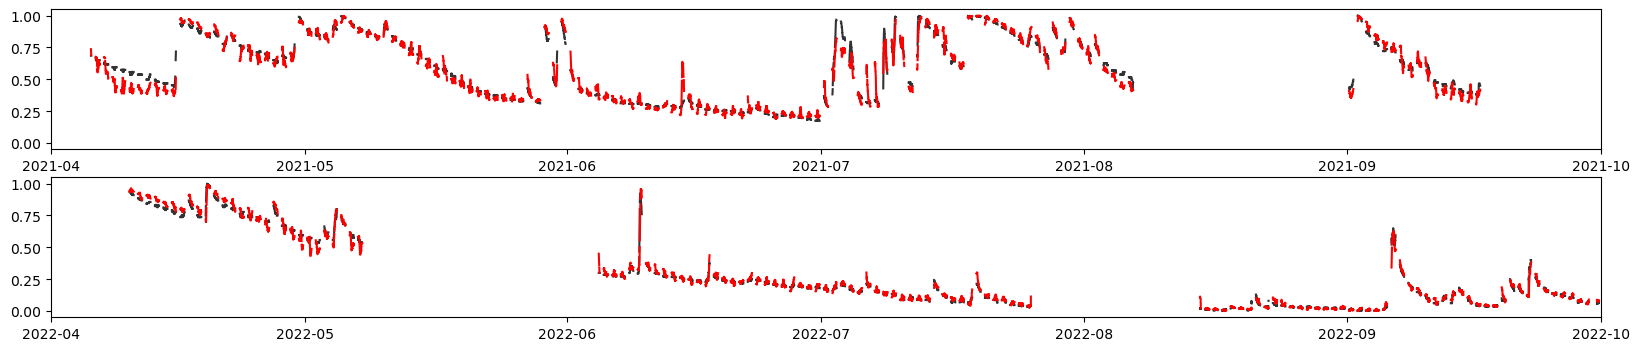

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20,4))
# ground truth
plot_timeseries_with_gaps(ax[1], exp_results_train, 'timestamp', 'ranked_flow_cfs', c=colors[-1], alpha=0.8)
plot_timeseries_with_gaps(ax[1], exp_results_val, 'timestamp', 'ranked_flow_cfs', c=colors[-1], alpha=0.8)
plot_timeseries_with_gaps(ax[1], exp_results_test, 'timestamp', 'ranked_flow_cfs', c=colors[-1], alpha=0.8)
# # predictions
# scatter_plot(ax[1], exp_results_train, 'timestamp', 'ranked_score', c=colors[4])
# scatter_plot(ax[1], exp_results_val, 'timestamp', 'ranked_score', c=colors[2])
# scatter_plot(ax[1], exp_results_test, 'timestamp', 'ranked_score', c=colors[5])
# smoothed predictions
plot_timeseries_with_gaps(ax[1], exp_results_train, 'timestamp', 'smoothed_ranked_score', c='red')
plot_timeseries_with_gaps(ax[1], exp_results_val, 'timestamp', 'smoothed_ranked_score', c='red')
plot_timeseries_with_gaps(ax[1], exp_results_test, 'timestamp', 'smoothed_ranked_score', c='red')

ax[1].set_xlim([np.datetime64('2022-04-01'), np.datetime64('2022-10-01')])


# ground truth
plot_timeseries_with_gaps(ax[0], exp_results_train, 'timestamp', 'ranked_flow_cfs', c=colors[-1], alpha=0.8)
plot_timeseries_with_gaps(ax[0], exp_results_val, 'timestamp', 'ranked_flow_cfs', c=colors[-1], alpha=0.8)
plot_timeseries_with_gaps(ax[0], exp_results_test, 'timestamp', 'ranked_flow_cfs', c=colors[-1], alpha=0.8)

# smoothed predictions
plot_timeseries_with_gaps(ax[0], exp_results_train, 'timestamp', 'smoothed_ranked_score', c='red')
plot_timeseries_with_gaps(ax[0], exp_results_val, 'timestamp', 'smoothed_ranked_score', c='red')
plot_timeseries_with_gaps(ax[0], exp_results_test, 'timestamp', 'smoothed_ranked_score', c='red')

ax[0].set_xlim([np.datetime64('2021-04-01'), np.datetime64('2021-10-01')])


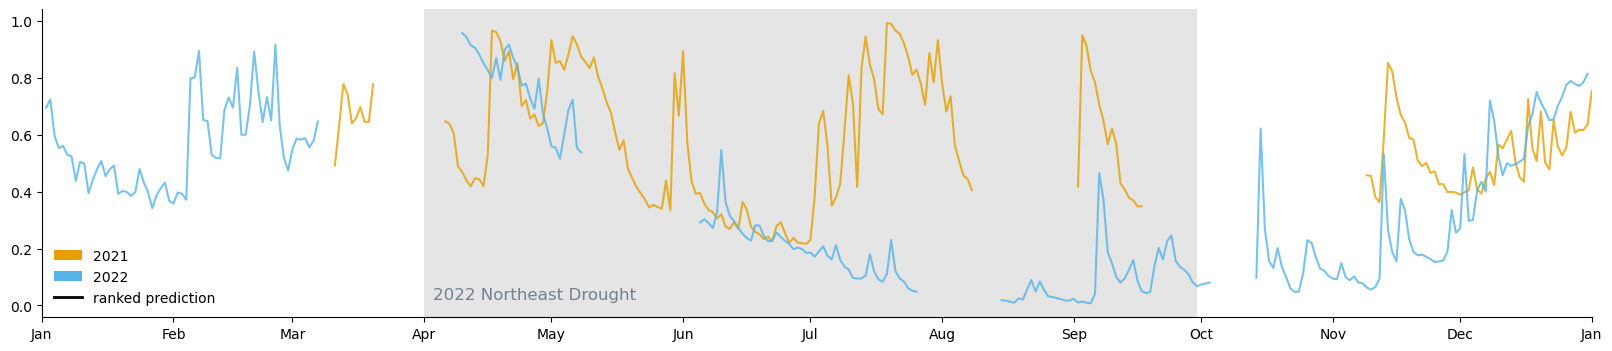

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20,4))
for i, year in enumerate([2021, 2022]):
    min_dt = pd.Timestamp(year, 1, 1, tz='UTC')
    max_dt = pd.Timestamp(year, 12, 31, tz='UTC')
    exp_results_year = filter_by_date(exp_results, min_dt, max_dt, mode="include")

    daily_flow_year = exp_results_year.groupby(exp_results_year['timestamp'].dt.dayofyear)['ranked_flow_cfs'].mean()
    # plot_timeseries_with_gaps(
    #     ax,
    #     daily_flow_year.to_frame().reset_index(),
    #     'timestamp',
    #     'ranked_flow_cfs',
    #     gap_threshold=1,
    #     gap_units='D',
    #     c=colors[i],
    #     alpha=0.8,
    #     label=year
    # )
    daily_score_year = exp_results_year.groupby(exp_results_year['timestamp'].dt.dayofyear)['ranked_score'].mean()
    plot_timeseries_with_gaps(
        ax,
        daily_score_year.to_frame().reset_index(),
        'timestamp',
        'ranked_score',
        gap_threshold=1,
        gap_units='D',
        c=colors[i],
        alpha=0.8,
        # linestyle='--'
        linestyle='-'
    )

xfmt = mdates.DateFormatter('%b')
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(xfmt)

custom_legend_items = [
    mpatches.Patch(facecolor=colors[0], edgecolor='none', label='2021'),
    mpatches.Patch(facecolor=colors[1], edgecolor='none', label='2022'),
    # mlines.Line2D([0], [0], color=colors[0], lw=2),
    # mlines.Line2D([0], [0], color=colors[1], lw=2),
    # mlines.Line2D([0], [0], color=colors[-1], lw=2, linestyle='-', label='ranked discharge'),
    # mlines.Line2D([0], [0], color=colors[-1], lw=2, linestyle='--', label='ranked prediction'),
    mlines.Line2D([0], [0], color=colors[-1], lw=2, linestyle='-', label='ranked prediction'),
]
ax.legend(
    custom_legend_items, 
    [
        '2021', 
        '2022',
        # 'ranked discharge',
        'ranked prediction'
    ],
    frameon=False
)
ax.set_xlim([0, 365])

# draw patch from april to september for drought period
start_x, end_x = pd.Timestamp('2022-04-01').dayofyear-1, pd.Timestamp('2022-09-30').dayofyear-1
plt.axvspan(start_x, end_x, color='gray', alpha=0.2, lw=0)
ax.text(start_x+2, 0.02, r'2022 Northeast Drought', fontsize=12, color='slategray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


,Unnamed: 0,station_name,station_id,imageset_id,image_id,timestamp,filename,url,flow_cfs,scores
0,0,West Brook 0_01171100,29,289,441411,2022-02-01 18:00:00+00:00,West Brook Master__2022-02-01__13-00-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.71,7.350419
1,1,West Brook 0_01171100,29,289,441412,2022-02-01 18:15:00+00:00,West Brook Master__2022-02-01__13-15-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.71,7.781502
2,2,West Brook 0_01171100,29,289,441413,2022-02-01 18:30:00+00:00,West Brook Master__2022-02-01__13-30-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.71,7.047587


,Unnamed: 0,station_name,station_id,imageset_id,image_id,timestamp,filename,url,flow_cfs,scores
0,0,Avery Brook_Bridge_01171000,12,95,153582,2021-03-10 16:01:17+00:00,Avery Bridge Downstream__2021-03-10__11-01-17(...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,3.39,-2.399337
1,1,Avery Brook_Bridge_01171000,12,95,153583,2021-03-10 16:02:24+00:00,Avery Bridge Downstream__2021-03-10__11-02-24(...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,3.39,-2.856064
2,2,Avery Brook_Bridge_01171000,12,95,153584,2021-03-10 16:16:18+00:00,Avery Bridge Downstream__2021-03-10__11-16-18(...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,3.39,-2.654353


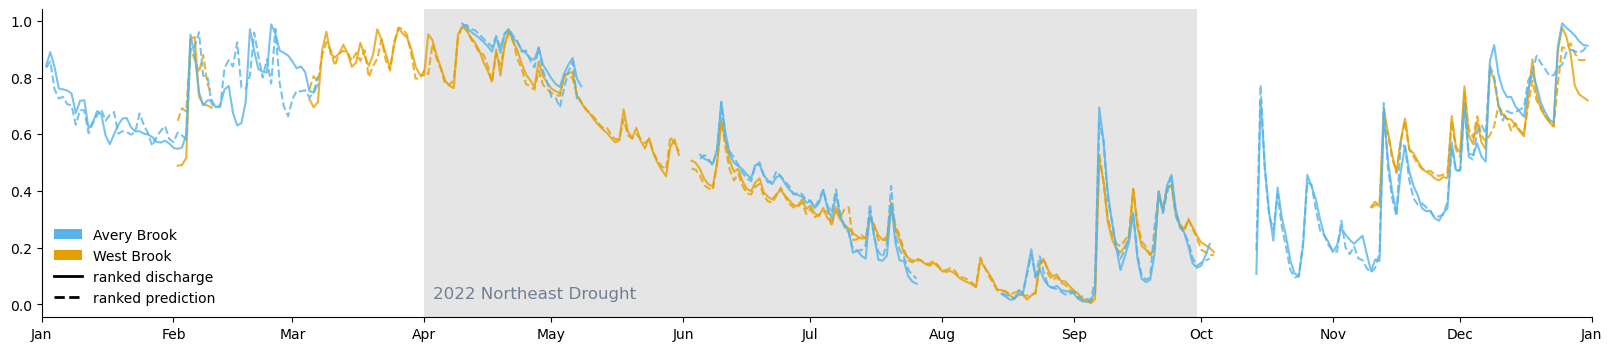

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20,4))
year = 2022
for i, run_idx in enumerate([1, 0]):
    exp_agg_row = exp_agg_df.iloc[run_idx]
    exp_results = pd.read_csv(exp_agg_row['inference_results_file'])
    exp_results = convert_col_to_timestamp(exp_results, 'timestamp')
    display(exp_results.head(3))

    # filter by date first for hacking comparable time series
    min_dt = pd.Timestamp(year, 1, 1, tz='UTC')
    max_dt = pd.Timestamp(year, 12, 31, tz='UTC')
    exp_results = filter_by_date(exp_results, min_dt, max_dt, mode="include")

    # compute percentile rank by flow_cfs and score for each sample
    exp_results['ranked_flow_cfs'] = exp_results['flow_cfs'].rank(pct=True)
    exp_results['ranked_score'] = exp_results['scores'].rank(pct=True)

    # compute a smoothed version of the ranked_score for plotting
    exp_results['smoothed_ranked_score'] = exp_results['ranked_score'].rolling(10).mean()

    min_dt = pd.Timestamp(year, 1, 1, tz='UTC')
    max_dt = pd.Timestamp(year, 12, 31, tz='UTC')
    exp_results_year = filter_by_date(exp_results, min_dt, max_dt, mode="include")

    daily_flow_year = exp_results_year.groupby(exp_results_year['timestamp'].dt.dayofyear)['ranked_flow_cfs'].mean()
    plot_timeseries_with_gaps(
        ax,
        daily_flow_year.to_frame().reset_index(),
        'timestamp',
        'ranked_flow_cfs',
        gap_threshold=1,
        gap_units='D',
        c=colors[i],
        alpha=0.8,
        label=year
    )
    daily_score_year = exp_results_year.groupby(exp_results_year['timestamp'].dt.dayofyear)['ranked_score'].mean()
    plot_timeseries_with_gaps(
        ax,
        daily_score_year.to_frame().reset_index(),
        'timestamp',
        'ranked_score',
        gap_threshold=1,
        gap_units='D',
        c=colors[i],
        alpha=0.8,
        linestyle='--'
    )

xfmt = mdates.DateFormatter('%b')
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(xfmt)

custom_legend_items = [
    mpatches.Patch(facecolor=colors[1], edgecolor='none', label='Avery Brook'),
    mpatches.Patch(facecolor=colors[0], edgecolor='none', label='West Brook'),
    # mlines.Line2D([0], [0], color=colors[0], lw=2),
    # mlines.Line2D([0], [0], color=colors[1], lw=2),
    mlines.Line2D([0], [0], color=colors[-1], lw=2, linestyle='-', label='ranked discharge'),
    mlines.Line2D([0], [0], color=colors[-1], lw=2, linestyle='--', label='ranked prediction'),
]
ax.legend(
    custom_legend_items, 
    [
        'Avery Brook', 
        'West Brook',
        'ranked discharge',
        'ranked prediction'
    ],
    frameon=False
)
ax.set_xlim([0, 365])

# draw patch from april to september for drought period
start_x, end_x = pd.Timestamp('2022-04-01').dayofyear-1, pd.Timestamp('2022-09-30').dayofyear-1
plt.axvspan(start_x, end_x, color='gray', alpha=0.2, lw=0)
ax.text(start_x+2, 0.02, r'2022 Northeast Drought', fontsize=12, color='slategray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [4]:
inference_results_root_dir = '../results/inference_ranking_model'
inference_experiment_dirs = os.listdir(inference_results_root_dir)
params = dict()
results = dict()
for inference_experiment_dir in inference_experiment_dirs:
    inference_experiment_path = os.path.join(inference_results_root_dir, inference_experiment_dir)
    inference_experiment_params = pickle.load(open(os.path.join(inference_experiment_path, 'params.pkl'), 'rb'))
    params[inference_experiment_dir] = inference_experiment_params
    inference_experiment_results_f = os.path.join(
        inference_experiment_path,
        "inference_results_" + os.path.basename(inference_experiment_params["inference_data_file"]),
    )
    inference_experiment_results = pd.read_csv(inference_experiment_results_f)
    inference_experiment_results['timestamp'] = pd.to_datetime(inference_experiment_results['timestamp'])
    results[inference_experiment_dir] = inference_experiment_results


,Unnamed: 0,station_name,station_id,imageset_id,image_id,timestamp,filename,url,flow_cfs,scores,ranked_flow_cfs,ranked_scores
1750,1750,West Brook 0_01171100,29,371,544320,2022-03-16 08:15:00+00:00,West Brook Master__2022-03-16__03-15-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,37.900000,13.693090,0.924706,0.962623
1751,1751,West Brook 0_01171100,29,371,544321,2022-03-16 08:30:00+00:00,West Brook Master__2022-03-16__03-30-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,37.900000,11.273830,0.924671,0.792826
1752,1752,West Brook 0_01171100,29,371,544322,2022-03-16 08:45:00+00:00,West Brook Master__2022-03-16__03-45-00(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,36.800000,4.958718,0.917382,0.497900
1753,1753,West Brook 0_01171100,29,371,544323,2022-03-16 08:59:59+00:00,West Brook Master__2022-03-16__03-59-59(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,36.800000,5.560630,0.917346,0.519120
1754,1754,West Brook 0_01171100,29,371,544324,2022-03-16 09:14:59+00:00,West Brook Master__2022-03-16__04-14-59(1).JPG,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,37.898778,3.672450,0.924599,0.465118


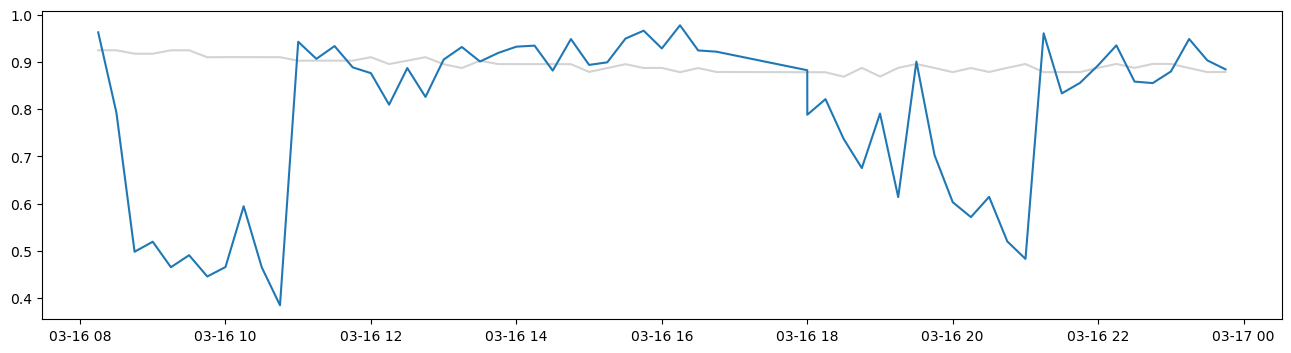

In [45]:
# results['inference_ranking_model_2'].head(40).tail(25)
# # # (kendalltau(results['inference_ranking_model_2']['flow_cfs'], results['inference_ranking_model_2']['scores']))
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ranked_flow_cfs = np.argsort(np.argsort(results['inference_ranking_model_2']['flow_cfs']))/len(results['inference_ranking_model_2']['flow_cfs'])
ranked_scores = np.argsort(np.argsort(results['inference_ranking_model_2']['scores']))/len(results['inference_ranking_model_2']['scores'])
results['inference_ranking_model_2']['ranked_flow_cfs'] = ranked_flow_cfs
results['inference_ranking_model_2']['ranked_scores'] = ranked_scores

min_date = pd.Timestamp('2022-03-16T08:00:00', tz='UTC')
after_min_date = results['inference_ranking_model_2']['timestamp'] >= min_date
max_date = pd.Timestamp('2022-03-17', tz='UTC')
before_max_date = results['inference_ranking_model_2']['timestamp'] <= max_date
filtered_results = results['inference_ranking_model_2'].loc[after_min_date & before_max_date]
# ax.plot(results['inference_ranking_model_2']['timestamp'], ranked_scores, color='lightgray')
# ax.plot(results['inference_ranking_model_2']['timestamp'], ranked_flow_cfs)
ax.plot(filtered_results['timestamp'], filtered_results['ranked_flow_cfs'], color='lightgray')
ax.plot(filtered_results['timestamp'], filtered_results['ranked_scores'])

# ax.set_xlim([np.datetime64('2022-07-01'), np.datetime64('2022-07-05')])
# ax.set_ylim([0.5, 0.7])

display(filtered_results.head())

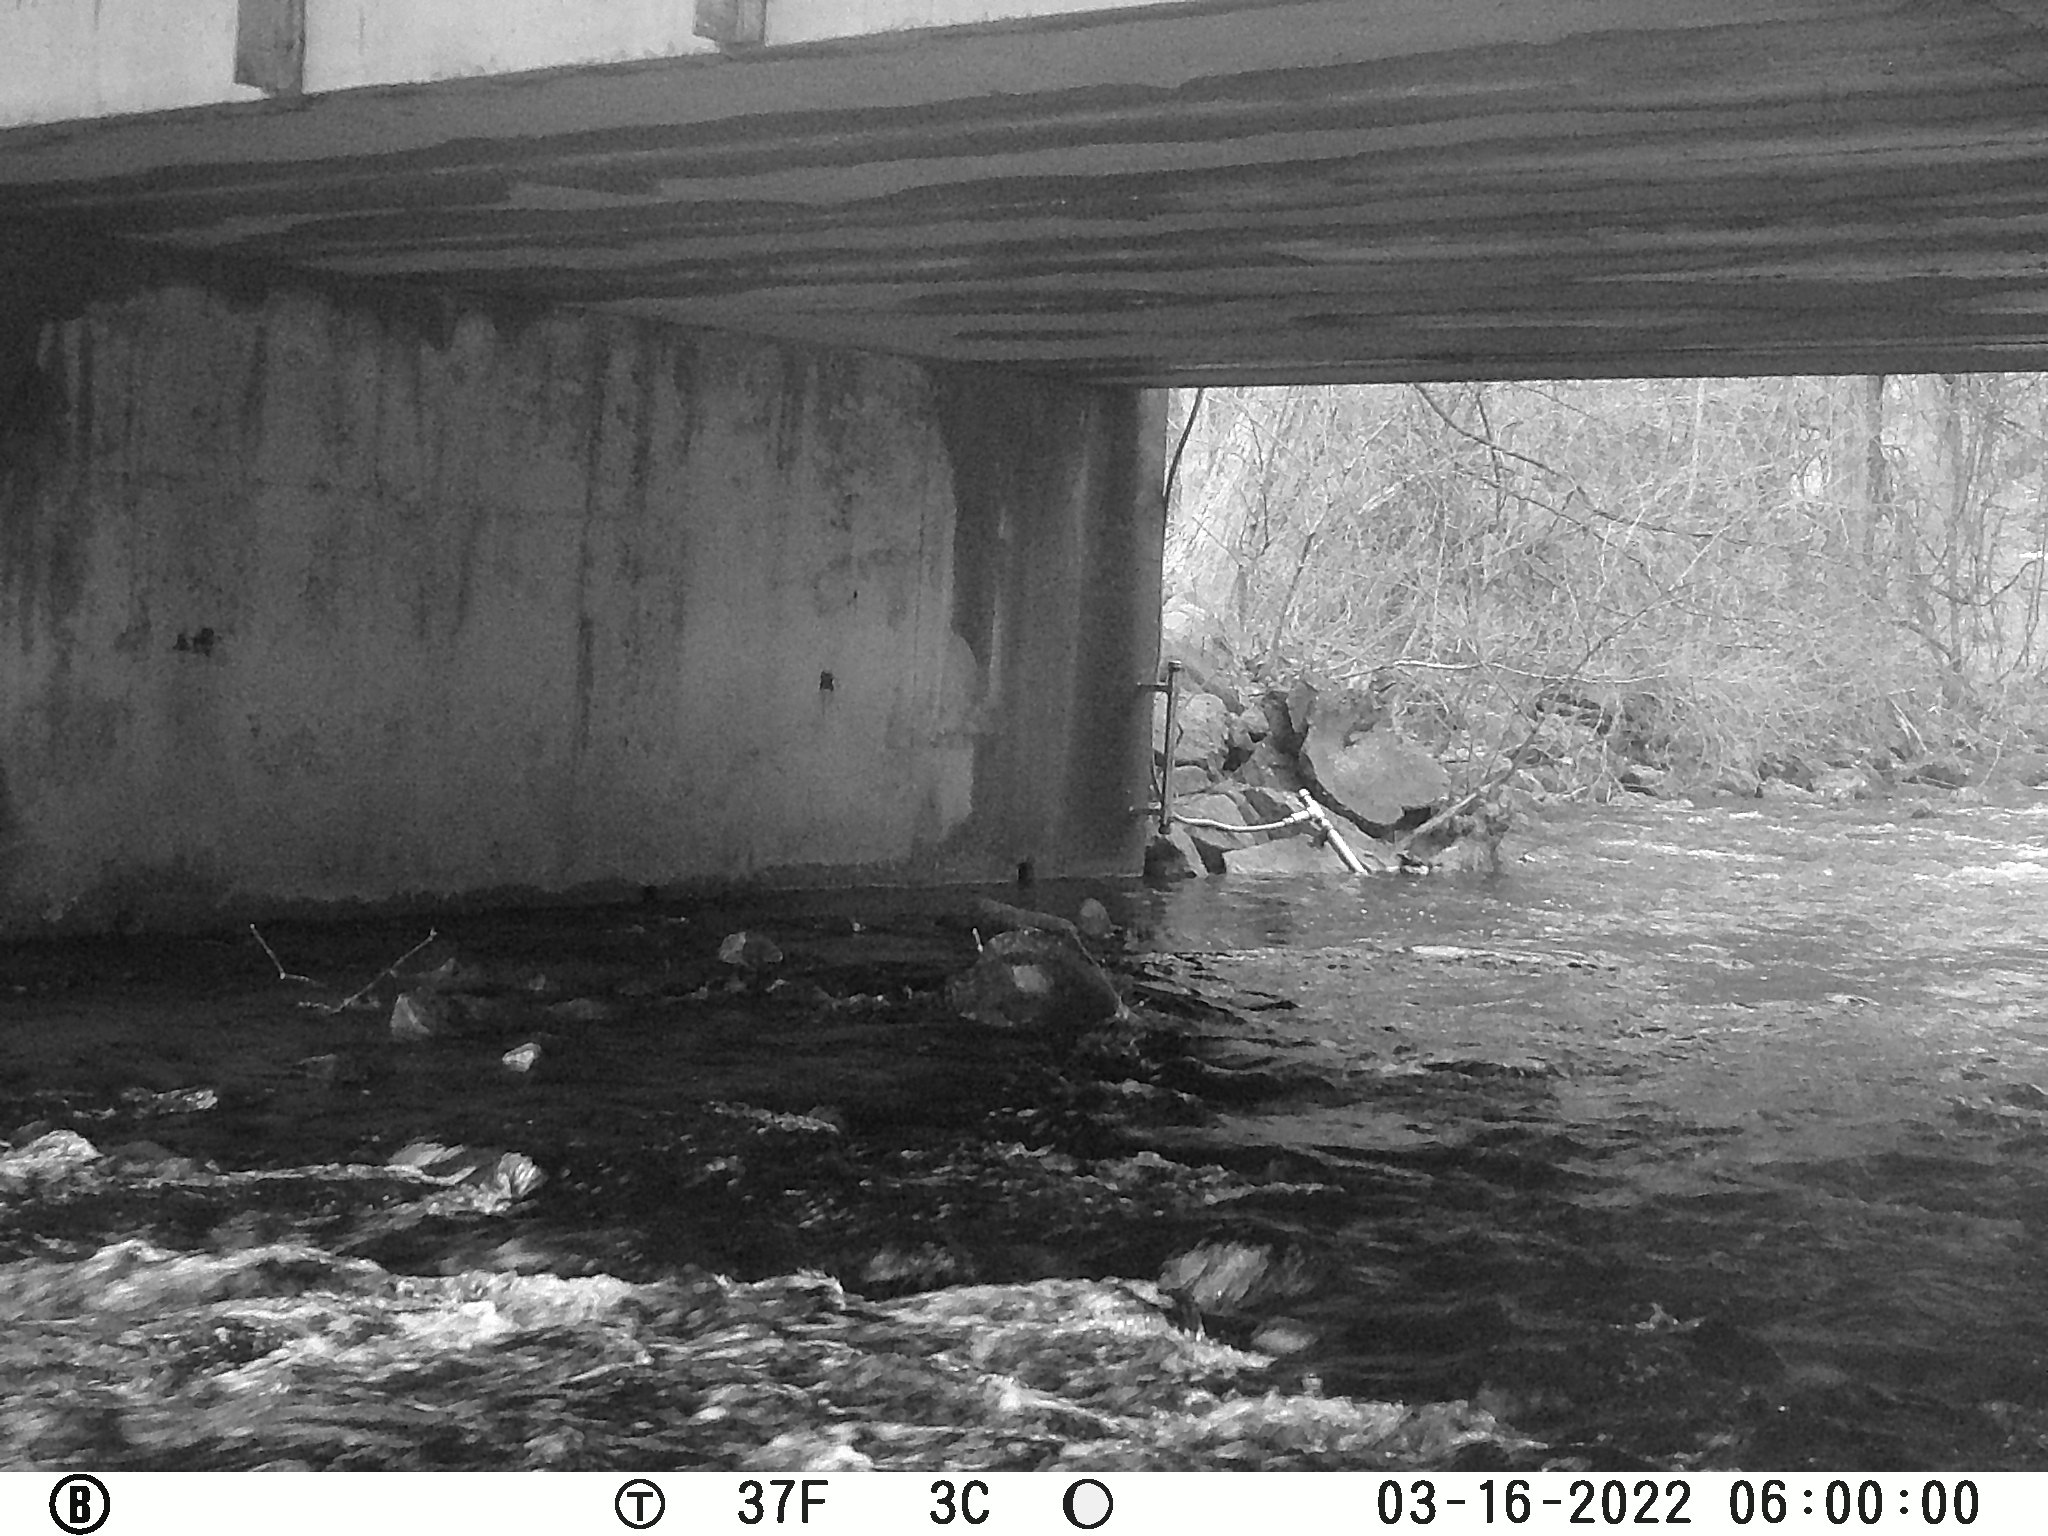

In [53]:
image_fn = filtered_results.iloc[11].filename
image_root_dir = params['inference_ranking_model_2']['inference_image_root_dir']
image_path = os.path.join(image_root_dir, image_fn)
with open(image_path, 'rb') as f:
    img = Image.open(f)
    display(img)

In [2]:
def get_loss_metrics_file(resdir, fn_params):
    if fn_params['model'] == 'ranking':
        loss_metrics_file_patt = 'metrics_per_epoch_%s_margin_%s_randompairs_%d_%s_augment_normalize_939.pkl'
        search_fn = loss_metrics_file_patt%(
            fn_params['model'], 
            str(fn_params['margin']), 
            fn_params['randompairs'],
            fn_params['site'],
        )
    elif fn_params['model'] == 'regression':
        loss_metrics_file_patt = 'metrics_per_epoch_%s_%s_augment_normalize_939.pkl'
        search_fn = loss_metrics_file_patt%(
            fn_params['model'], 
            fn_params['site'],
        )
    if os.path.exists(os.path.join(resdir, search_fn)):
        return os.path.join(resdir, search_fn)
    return None

In [3]:
def get_checkpoint_file(resdir, fn_params):
    if fn_params['model'] == 'ranking':
        epoch_file_patt = 'epoch%s_%s_margin_%s_randompairs_%d_%s_augment_normalize_939.ckpt'
        search_fn = epoch_file_patt%(
            str(fn_params['epoch']),
            fn_params['model'], 
            str(fn_params['margin']), 
            fn_params['randompairs'],
            fn_params['site'],
        )
    elif fn_params['model'] == 'regression':
        epoch_file_patt = 'epoch%s_%s_%s_augment_normalize_939.ckpt'
        search_fn = epoch_file_patt%(
            str(fn_params['epoch']),
            fn_params['model'], 
            fn_params['site'],
        )
    if os.path.exists(os.path.join(resdir, search_fn)):
        return os.path.join(resdir, search_fn)
    return None

In [4]:
algs = [
    # ('ranking', 0.0),
    ('ranking', 0.1),
    # ('ranking', 0.2),
#     ('ranking', 0.5),
#     ('regression',)
]
site = 'AVERYBB'

In [5]:
loss_metrics = dict()
for alg in algs:
    print(alg)
    save_dir = '../results'
    if alg[0] == 'ranking':
        expt_params = {
            'model': alg[0],
            'margin': alg[1],
            'site': site,
            'randompairs': 5000
        }
    else:
        expt_params = {
            'model': alg[0],
            'site': site,
        }
    metrics_f = get_loss_metrics_file(save_dir, expt_params)
    loss_metrics[(*alg,)] = pickle.load(open(metrics_f, 'rb'))
    loss_metrics[(*alg,)]['best_ckpt_idx'] = np.argmin(loss_metrics[(*alg,)]['val_loss'])

('ranking', 0.1)


In [6]:
loss_metrics

{('ranking',
  0.1): {'training_loss': [0.6484905990066042,
   0.5218320735700571,
   0.3183026705767698,
   0.22713149509801986,
   0.19008081838203844,
   0.17185714660556453,
   0.15675813410502332,
   0.14567370212097078,
   0.14242016637970686,
   0.13782211896150734,
   0.13033567269326776,
   0.12942941529545815,
   0.12087013733804605,
   0.1177012719641066,
   0.12110549346751469], 'val_loss': [0.6181965097784996,
   0.5062707299366593,
   0.25161735201254487,
   0.21589833358302712,
   0.19535906496457756,
   0.195886843604967,
   0.19244351889938116,
   0.1840590969659388,
   0.19070296152494848,
   0.1960082594305277,
   0.17747428151778877,
   0.18443004228174686,
   0.17425828892737627,
   0.17699615377932787,
   0.17843431304208934], 'test_loss': [0.6132751703262329,
   0.49779094755649567,
   0.2590030231513083,
   0.21935999812558293,
   0.20451915496960282,
   0.18940826132893562,
   0.19152165902778506,
   0.19193702726624906,
   0.1844547032378614,
   0.182538285851

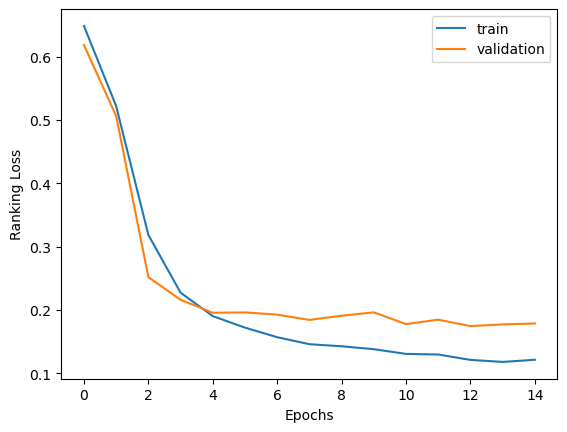

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.plot(loss_metrics[(*alg,)]['training_loss'], label='train')
ax.plot(loss_metrics[(*alg,)]['val_loss'], label='validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Ranking Loss')
ax.legend()
plt.show()

In [8]:
for expt in loss_metrics.keys():
    if expt[0] == 'ranking':
        resdir = '../results'
        expt_params = {
            'model': expt[0],
            'margin': expt[1],
            'site': site,
            'randompairs': 5000,
            'epoch': loss_metrics[expt]['best_ckpt_idx']
        }
        ckpt_f = get_checkpoint_file(os.path.join(resdir, 'checkpoints'), expt_params)
        if site == 'AVERYBB':
            datafile = '../data/interim/Avery_Brook_Bridge_01171000/exclude_pii/flow-images-md_v5a_0.2.csv'
            image_root_dir = '../data/raw/Avery_Brook_Bridge_01171000/images'
        args = {
            'seed': 939, 
            'data_file': datafile,
            'image_root_dir': image_root_dir,
            'min_hour': 7,
            'max_hour': 18,
            'min_month': 4,
            'max_month': 11,
            # 'arch': 'ResNet18', 
            'truncate': 2, 
            'site': site, ## GETS UPDATED
            # 'split_idx': expt[2], ## GETS UPDATED
            'normalize': True, 
            'augment': True, 
            # 'crop_to_bbox': False, 
            'test_batch_size': 64,
            'margin': expt[1], ## GETS UPDATED
            'margin_mode': 'relative',
            'num_train_pairs': 5000,
            'num_eval_pairs': 1000,
            'save_dir': resdir,
            'ckpt_path': ckpt_f ## GETS UPDATED
        }
        args_ns = Namespace(**args)
        train_res, val_res, test_res = inference_ranknet(args_ns)
    elif expt[0] == 'regression':
        resdir = '../results'
        # expt_params = {
        #     'model': expt[0],
        #     'site': site,
        #     'split_idx': expt[1],
        #     'randompairs': 500,
        #     'epoch': loss_metrics[expt]['best_ckpt_idx']
        # }
        # ckpt_f = get_checkpoint_file(resdir, expt_params)
        # args = {
        #     'seed': 939, 
        #     'arch': 'ResNet18', 
        #     'truncate': 2, 
        #     'site': site, ## GETS UPDATED
        #     'split_idx': expt[1], ## GETS UPDATED
        #     'normalize': True, 
        #     'augment': True, 
        #     'crop_to_bbox': False, 
        #     'batch_size': 64,
        #     'save_dir': resdir,
        #     'ckpt_path': ckpt_f ## GETS UPDATED
        # }
        # train_res, val_res, test_res = inference_regression(args)

Namespace(seed=939, data_file='../data/interim/Avery_Brook_Bridge_01171000/exclude_pii/flow-images-md_v5a_0.2.csv', image_root_dir='../data/raw/Avery_Brook_Bridge_01171000/images', min_hour=7, max_hour=18, min_month=4, max_month=11, truncate=2, site='AVERYBB', normalize=True, augment=True, test_batch_size=64, margin=0.1, margin_mode='relative', num_train_pairs=5000, num_eval_pairs=1000, save_dir='../results', ckpt_path='../results/checkpoints/epoch12_ranking_margin_0.1_randompairs_5000_AVERYBB_augment_normalize_939.ckpt')


100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


DATALOADERS CREATED!
Using 8 GPU(s) for eval.


/home/amritagupta/.conda/envs/streamflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amritagupta/.conda/envs/streamflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MODEL LOADED!


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


In [9]:
import pandas as pd
from scipy.stats import kendalltau

In [11]:
partition = 'test'
expts = [('ranking', 0.1),]

ktau = dict()

for e in expts:
    alg, margin = e
    
    # get path to directory with results for this experiment
    res_dir = '../results'
    
    # get test set results file
    all_pred_files = [f for f in os.listdir(res_dir) if 'pred' in f]
    site_pred_files = [f for f in all_pred_files if site in f]
    site_partition_pred_files = sorted([f for f in site_pred_files if partition in f])
#     assert len(site_partition_pred_files) == 10, 'We might be missing results for some splits?'
    
    ktau[e] = dict()
    ktau[e]['tau'] = []
    ktau[e]['p_value'] = []
    
    for i,f in enumerate(site_partition_pred_files):
#         if i == 5:
#             break
        df = pd.read_csv(os.path.join(res_dir, f))
        disch = df['flow_cfs'].values
        if alg == 'ranking':
            pred = df['scores'].values
        elif alg == 'regression':
            pred = df['preds'].values
        tau, p_value = kendalltau(disch, pred)
        ktau[e]['tau'].append(tau)
        ktau[e]['p_value'].append(p_value)


In [12]:
ktau

{('ranking', 0.1): {'tau': [0.8789731494715386], 'p_value': [0.0]}}

Text(0, 0.5, 'ranking model predicted score')

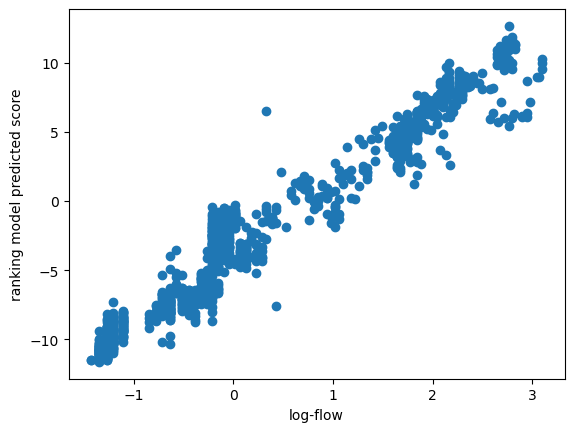

In [18]:
fix, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(np.log(disch), pred)
ax.set_xlabel('log-flow')
ax.set_ylabel('ranking model predicted score')
# plt.scatter(disch, pred)